# DPCM Card Game Simulator

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import ast
from moviepy.editor import ImageSequenceClip

### Variables

In [2]:
white = '#ffffff'
orange = '#ff4500'
purple = '#7f00ff'
black = '#000000'

### Number of turns

In [3]:
def get_turns_graph(file_path):
    df = pd.read_csv(file_path)

    fig = plt.figure(1, figsize=(12, 6))

    n, bins, patches = plt.hist(df['Turns'], bins=np.arange(0, max(df['Turns']), 5), color=purple, edgecolor='w', rwidth=0.95)

    x = range(max(df['Turns']))
    plt.xticks(np.arange(min(x), max(x)+10, 5))

    n = list(n)
    patches[n.index(max(n))].set_fc(orange)

    plt.xlabel('Turns per Game')
    plt.ylabel('Number of games')

    plt.title('Turns Distribution')

    plt.show()

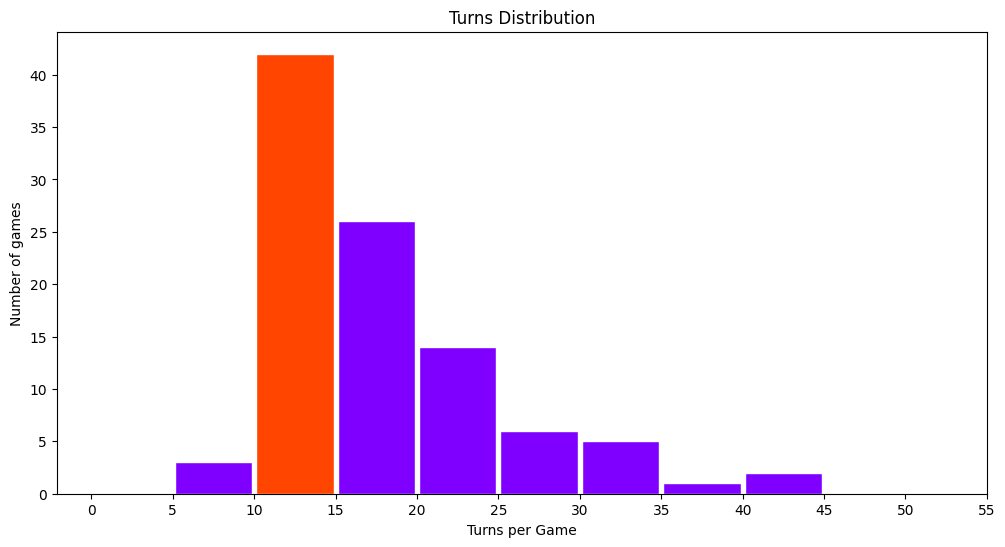

In [4]:
get_turns_graph('../data/results.csv')

### Fair VS Not-Fair Games

In [5]:
def get_fair_graph():
    fig = plt.figure(1, figsize=(12, 6))

    not_fair_file = 'not_fair.csv'
    fair_file = 'fair.csv'

    not_fair_df = pd.read_csv('../data/' + not_fair_file)
    fair_df = pd.read_csv('../data/' + fair_file)

    plt.plot(not_fair_df.index, not_fair_df['Rate'], color = orange, label='Win-Rate not fair')
    plt.plot(fair_df.index, fair_df['Rate'], color = purple, label='Win-Rate fair')

    plt.hlines(0.5, 0, len(not_fair_df), colors='black', linestyles='dashed')

    plt.title('Win Rate with Starting Advantage')

    plt.legend(loc='lower right')

    plt.xlabel('Games')
    plt.ylabel('Win Rate')

    plt.show()

    print(f'{abs(not_fair_df['Rate'].iloc[-1] - fair_df['Rate'].iloc[-1])*100:.2f}%')

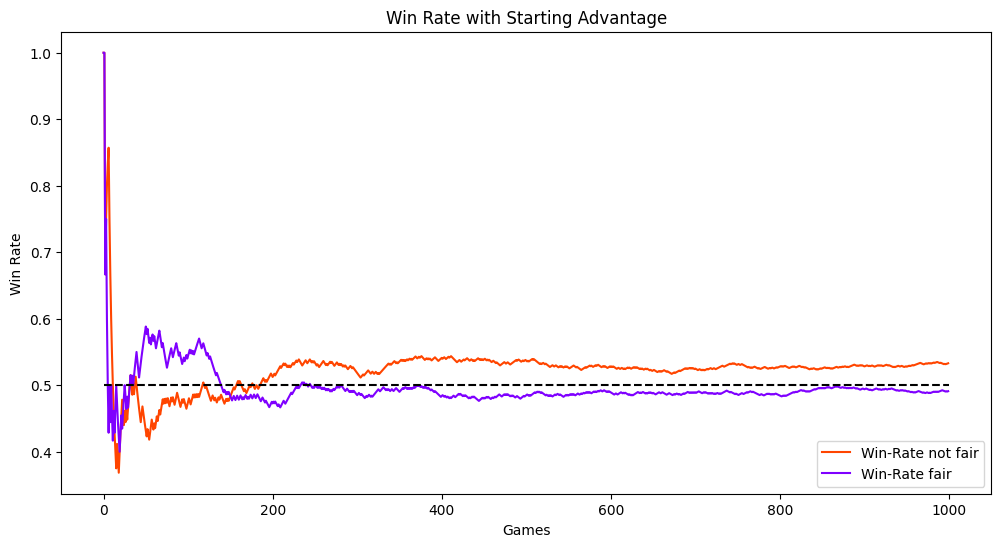

4.20%


In [6]:
get_fair_graph()

### Human VS AI

In [7]:
def get_human_ai_graph(file_path_human, file_path_ai):
    df_human = pd.read_csv(file_path_human)
    df_ai = pd.read_csv(file_path_ai)

    fig = plt.figure(1, figsize=(12, 6))

    plt.plot(df_human.index, df_human['Rate'], color=purple, label='Human')
    plt.plot(df_ai.index, df_ai['Rate'], color=orange, label='AI')

    plt.hlines(0.5, 0, len(df_human), colors='black', linestyles='dashed')

    plt.title('Win Rate with Starting Advantage')

    plt.legend(loc='lower right')

    plt.xlabel('Games')
    plt.ylabel('Win Rate')

    plt.show()

    print(f'{abs(df_human['Rate'].iloc[-1] - df_ai['Rate'].iloc[-1])*100:.2f}%')

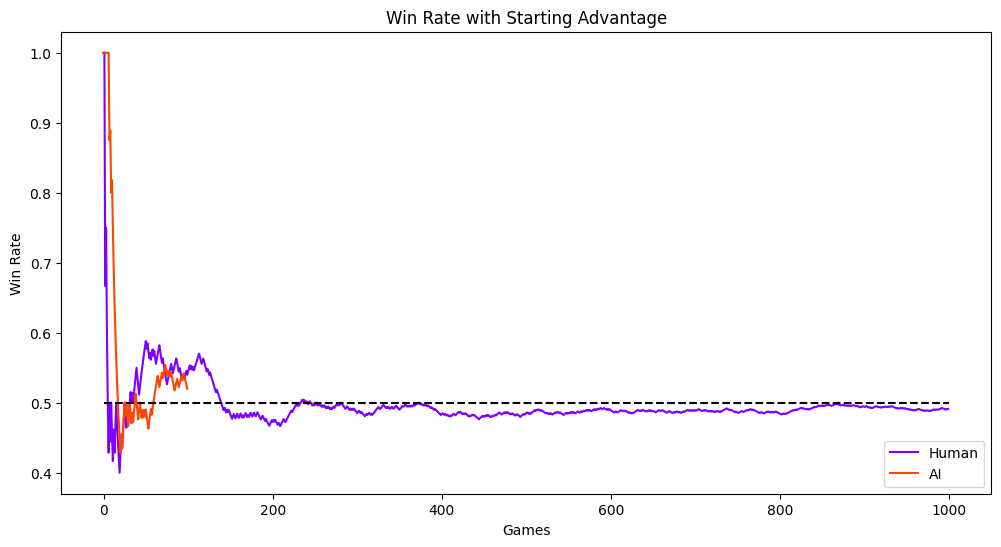

2.90%


In [8]:
get_human_ai_graph('../data/fair.csv', '../data/results.csv')

### Card most played

In [9]:
def get_visits_graph(file_path):
    df = pd.read_csv(file_path)

    df['MAX'] = df.iloc[:, 1:].max(axis=1)
    df['HAND'] = df['ID'].apply(lambda x: sum(eval(x)[3:]))

    df_pivot = df.drop(columns='MAX').iloc[:, 1:].groupby('HAND').sum()
    df_pivot = df_pivot.replace(0, np.NaN)
    df_pivot = df_pivot.dropna(how='all')

    fig, ax = plt.subplots(1, 1, figsize = (13, 7))

    cmap_custom = LinearSegmentedColormap.from_list('custom', [white, orange, black])

    sns.heatmap(df_pivot, 
                fmt='.0f', 
                linewidth = 0.3, 
                annot = True,
                cbar = True,
                cmap=cmap_custom,
                square=True)

    ax.title.set_text('Visits')

    ax.set(xlabel='Move taken', ylabel='Hand Cards Playable')

    plt.show()

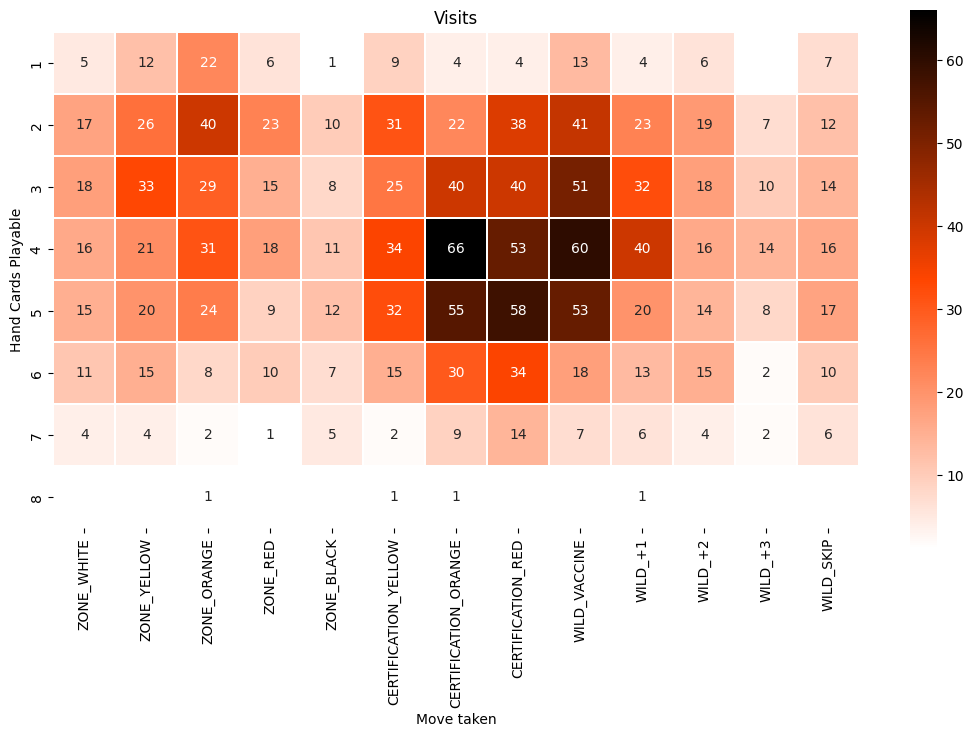

In [10]:
get_visits_graph('../data/visited.csv')

### Exploration

In [11]:
def get_exploration_graph(file_path):
    df = pd.read_csv(file_path)
    df['Cumsum'] = df['Visits'].cumsum()

    fig = plt.figure(1, figsize=(6, 6))

    x = np.linspace(0, max(df.index))
    y = x

    plt.plot(df.index, df['Cumsum'], color = orange, label='Coverage')
    plt.plot(x, y, color = 'black', label='Linear', linestyle='--')

    plt.title('State/Move Coverage')

    plt.legend(loc='lower right')

    plt.xlabel('Turns of games')
    plt.ylabel('State/Move Pairs Visited')

    plt.show()

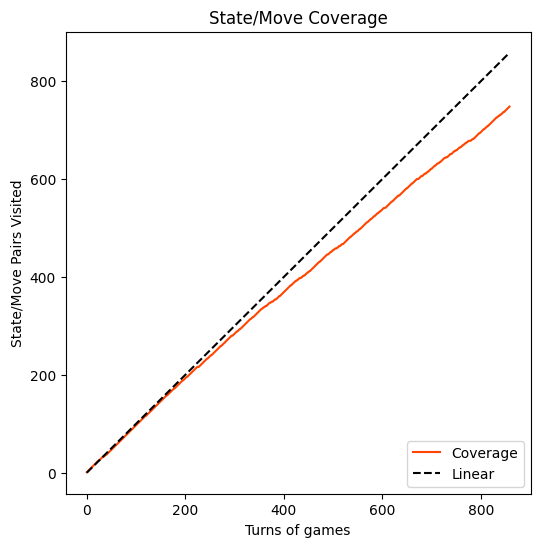

In [12]:
get_exploration_graph('../data/visits.csv')

### Number of cards playable

In [13]:
def get_cards_playable_graph(file_path):
    df = pd.read_csv(file_path)
    df['VISITS'] = df.iloc[:, 1:].max(axis=1)
    df = df[df['VISITS'] > 0]
    df = df[['ID', 'VISITS']].copy()
    df['ID'] = df['ID'].apply(ast.literal_eval)
    df['HAND'] = df['ID'].apply(lambda x: x[3:])
    df['HAND'] = df['HAND'].apply(lambda x: sum(x))
    df = df.drop('ID', axis=1)
    df = pd.DataFrame(df.groupby('HAND')['VISITS'].sum())
    df.reset_index(drop=False, inplace=True)
    df['PERCENTAGE'] = round((df['VISITS'] / df['VISITS'].sum())*100, 2)
    df = df.drop('VISITS', axis=1)

    fig = plt.figure(1, figsize=(12, 6))

    highest_bar = df.loc[df['PERCENTAGE'].idxmax()]

    plt.bar(df['HAND'], df['PERCENTAGE'], color=purple, edgecolor='w')
    plt.bar(highest_bar['HAND'], highest_bar['PERCENTAGE'], color=orange)

    plt.xticks(df['HAND'])

    plt.xlabel('Playable Cards in hand')
    plt.ylabel('Occurences %')

    plt.title('Number of playable Cards')

    plt.show()

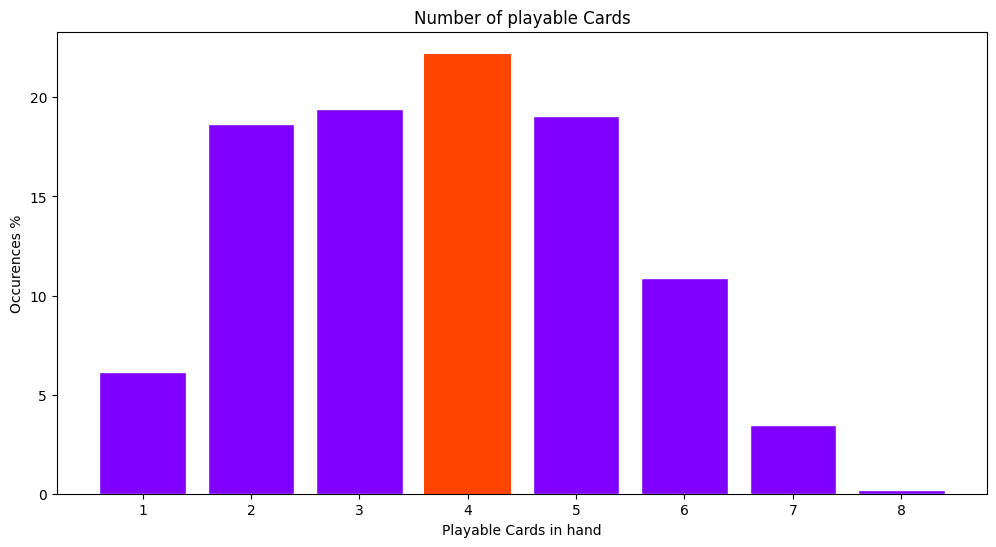

In [14]:
get_cards_playable_graph('../data/visited.csv')

#### Q-Values

In [15]:
def get_q_plot(file_path):
    df = pd.read_csv(file_path)
    df['MAX'] = df.iloc[:, 1:].max(axis=1)
    df['HAND'] = df['ID'].apply(lambda x: sum(eval(x)[3:]))
    
    df[['HAND', 'MAX']] = df[['HAND', 'MAX']].replace(0, np.NaN)
    df = df.dropna()

    q_mean = pd.Series(df.iloc[:, 1:].groupby('HAND').mean()['MAX'])
    q_max  = pd.Series(df.iloc[:, 1:].groupby('HAND').max()['MAX'])
    q_std  = pd.Series(df.iloc[:, 1:].groupby('HAND').std()['MAX']) / 2

    fig = plt.figure(1, figsize=(12, 6))

    plt.plot(q_mean.index, q_mean, label='Mean', marker='o', color=purple)
    plt.plot(q_max.index,  q_max,  label='Max',  marker='o', color=orange)

    plt.fill_between(q_mean.index, q_mean - q_std, q_mean + q_std, alpha=1/5, color=purple, edgecolor=None)

    plt.xticks(q_mean.index)

    plt.xlabel('Number of Minimum Hand Cards')
    plt.ylabel('Q-Value')

    plt.title('Q-Values')

    plt.legend()

    plt.show()

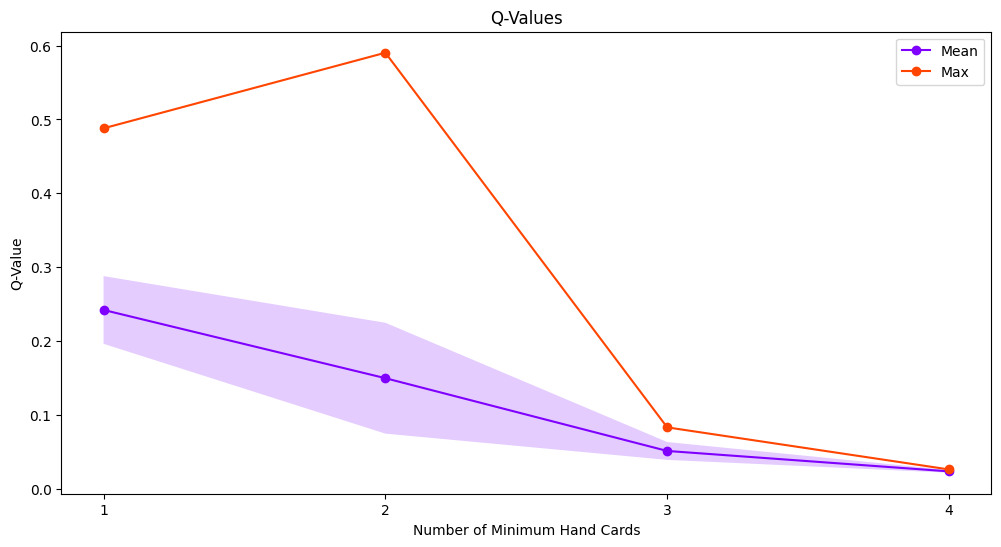

In [16]:
get_q_plot('../data/q.csv')

In [17]:
def get_q_heatmap(file_path):

    df = pd.read_csv(file_path)
    df['MAX'] = df.iloc[:, 1:].max(axis=1)
    df['HAND'] = df['ID'].apply(lambda x: sum(eval(x)[3:]))

    df = df.replace(0, np.NaN)
    df = df.drop(columns='MAX').iloc[:, 1:].groupby('HAND').mean()
    df = df.dropna(how='all')

    fig, ax = plt.subplots(1, 1, figsize = (12, 6))

    cmap_custom = LinearSegmentedColormap.from_list('custom', [white, orange, black])

    sns.heatmap(df, 
                fmt='.2f', 
                linewidth = 0.3, 
                annot = True,
                cbar = True,
                cmap=cmap_custom,
                square=True)

    ax.title.set_text('Visits')

    ax.set(xlabel='Move taken', ylabel='Hand Cards Playable')

    plt.show()

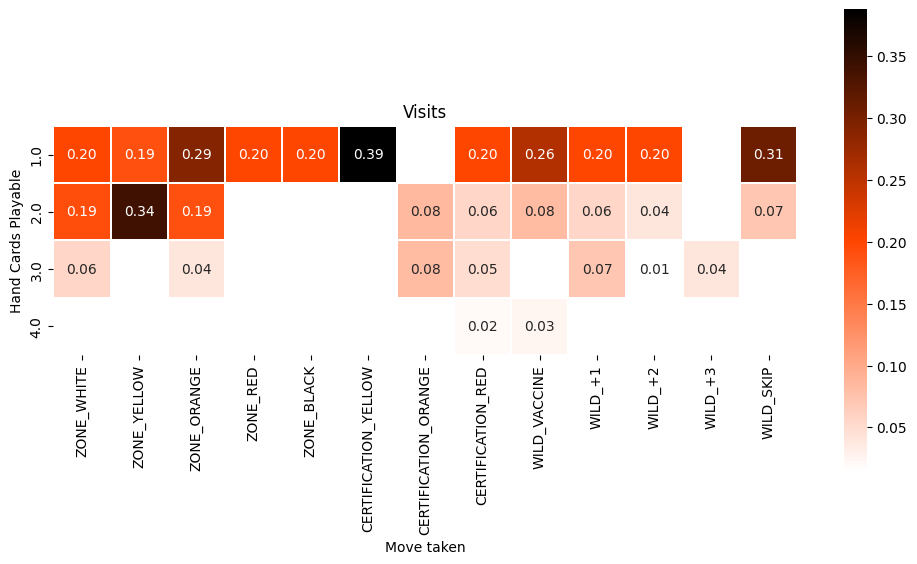

In [18]:
get_q_heatmap('../data/q.csv')

### Strategy

In [32]:
def get_df_range(df, min, max):
    return df.iloc[min:max, :]

In [33]:
def before_after_filter(riga):
    for i in range(len(riga['Before'])):
        if riga['Before'][i] >= riga['After'][i]:
            continue
        else:
            return False
    return True

In [34]:
def before_certifications_filter(riga):
    for i in range(5, 8):
        if riga['Before'][i] == 1:
            continue
        else:
            return False
    return True

In [35]:
def find_differences(before, after):
    return [i for i, (card1, card2) in enumerate(zip(before, after)) if card1 != card2]

In [36]:
def plot_strategy_heatmap(df):
    heatmap_data = df.pivot(index='CERTIFICATION', columns='ZONE', values='Percentage')

    zones_order = ['WHITE', 'YELLOW', 'ORANGE', 'RED']
    certifications_order = ['RED', 'ORANGE', 'YELLOW']

    heatmap_data = heatmap_data.loc[certifications_order, zones_order]

    fig, ax = plt.subplots(1, 1, figsize = (10, 6))

    sns.heatmap(heatmap_data,
                linewidth = 5,
                annot=True,
                vmin=0,
                vmax=1,
                cmap='rocket_r',
                cbar = True,
                fmt='.0%',
                square=True)

    plt.show()

In [37]:
def get_stability(df, df_previous):
    return abs(df['Percentage'] - df_previous['Percentage']).mean()

In [38]:
def get_strategy_heatmap(df, min, max, df_previous=None):
    df = get_df_range(df, min, max)

    df.loc[:, 'Before'] = df['Before'].apply(ast.literal_eval)
    df.loc[:, 'After'] = df['After'].apply(ast.literal_eval)

    df.loc[:, 'Before'] = df['Before'].apply(lambda x: x[3:11])
    df.loc[:, 'After'] = df['After'].apply(lambda x: x[3:11])

    df = df[df['Before'] != df['After']]

    df = df[df.apply(before_after_filter, axis=1)]

    df = df[df.apply(before_certifications_filter, axis=1)]

    df['Differences'] = df.apply(lambda row: find_differences(row['Before'], row['After']), axis=1)

    df = df[(df['Differences'].apply(len) > 1) & (df['Differences'].apply(len) < 3)]

    df.loc[:, 'Differences'] = df['Differences'].apply(tuple)

    df = pd.concat([df, df.iloc[[0]]], ignore_index=True)

    df = pd.DataFrame(df.groupby('Differences').size()).reset_index(drop=False)

    df.columns = ['Differences', 'Count']

    df[['ZONE', 'CERTIFICATION']] = df['Differences'].apply(lambda x: pd.Series([x[0], x[1]]))

    df.drop(columns=['Differences'], inplace=True)

    df = df[df['ZONE'] < 4]
    df = df[df['CERTIFICATION'] > 4]

    state_seen_group = df.groupby('ZONE')['Count'].transform('sum')

    df['Percentage'] = df['Count'] / state_seen_group

    df.drop(columns=['Count'], inplace=True)

    zones = {0: 'WHITE', 1: 'YELLOW', 2: 'ORANGE', 3: 'RED'}
    certifications = {5: 'YELLOW', 6: 'ORANGE', 7: 'RED'}

    df['ZONE'] = df['ZONE'].replace(zones)
    df['CERTIFICATION'] = df['CERTIFICATION'].replace(certifications)

    df.reset_index(drop=True, inplace=True)

    plot_strategy_heatmap(df)

    stability = None
    if df_previous is not None:
        stability = get_stability(df, df_previous)
    
    return df, stability 

In [39]:
def generate_tuples(max, interval):
    tuple_list = []
    for i in range(0, max, interval):
        tuple_list.append((i, min(i + interval, max)))
    return tuple_list

In [40]:
state_seen_df = pd.read_csv('../data/state_seen.csv')
print(len(state_seen_df))

992


In [41]:
tuple_list = generate_tuples(len(state_seen_df), 10000)
previous_df = None
stability_list = []
for min_max in tuple_list:
    try:
        df, stability = get_strategy_heatmap(state_seen_df, min_max[0], min_max[1], previous_df)
        previous_df = df
        stability_list.append(stability)
    except:
        pass

In [42]:
stability_list

[]

In [ ]:
fig = plt.figure(1, figsize=(7, 5))

plt.plot(stability_list, color=orange, label='Stability', linewidth=5)

plt.title('Stability Index')

plt.legend(loc='lower right')

plt.xlabel('Group of turns')
plt.ylabel('Stability Index')

plt.show()

In [ ]:
get_strategy_heatmap(state_seen_df, 0, len(state_seen_df))

In [ ]:
image_files = ['../img/strategy-heatmap-0.png', '../img/strategy-heatmap-1.png', '../img/strategy-heatmap-2.png', '../img/strategy-heatmap-3.png', '../img/strategy-heatmap-4.png']

durations = [500] * 5

clip = ImageSequenceClip(image_files, durations=durations)

clip.write_gif('../img/strategy-heatmap.gif', fps=1)